In [1]:
import datetime

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pyradiance as pr

### Make a scene

In [36]:
my_scene = pr.Scene(
    "my_scene",
    surfaces=["Objects/room.rad"],
    materials=["Objects/materials.mat"])
# dir 
# ['__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', 
# '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__',
#  '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', 
# 'hn2', 'hoff', 'horiz', 'hvec', 'type', 'vaft', 'vdir', 'vdist', 'vert', 'vfore', 'vn2', 'voff', 'vp', 'vu', 'vvec']
my_view = pr.View()
my_view.type = 'a'
my_view.vp = (6, 6, 4)
my_view.vdir = (0, -1, 0)
my_view.vu = (0, 0, 1)
my_view.horiz = 180 # horizontal field of view in degrees
my_view.vert = 180 # vertical field of view in degrees
my_view.hn2 = 800 # horizontal resolution
my_view.vn2 = 800 # vertical resolution

my_scene.add_view(my_view)

dt = datetime.datetime.now()
for prim in pr.parse_primitive(pr.gendaylit(dt, 37, 122, 120, dirnorm=800, diffhor=80).decode()):
    my_scene.add_source(prim)
my_scene.add_source(pr.Primitive("skyfunc", "glow", "skyglow", [], [1, 1, 1, 0]))
my_scene.add_source(pr.Primitive("skyglow", "source", "skydome", [], [0, 0, 1, 180]))
my_scene.add_source(pr.Primitive("skyglow", "source", "groundplane", [], [0, 0, -1, 180]))

### Render

In [37]:
# def render(
#     scene,
#     view: None | View = None,
#     quality: str = "Medium",
#     variability: str = "Medium",
#     detail: str = "Medium",
#     nproc: int = 1,
#     ncssamp: int = 3,
#     resolution: None | tuple[int, int] = None,
#     ambbounce: int = 0,
#     ambcache: bool = True,
#     params: None | RayParams = None,
# ) -> bytes:
#     """Render a scene.

#     Args:
#         scene: Scene object.
#         quality: Quality level.
#         variability: Variability level.
#         detail: Detail level.
#         nproc: Number of processes to use.
#         ambbounce: Number of ambient bounces.
#         ambcache: Use ambient cache.
#         params: Sampling parameters.

#     Returns:
#         tuple[bytes, int, int]: output of render, width, height
#     """
img = pr.render(my_scene, resolution=(800, 800), ambbounce=1, nproc=16, quality="L")
# img = pr.render(my_scene, ambbounce=1)

### Tone-mapping

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.00049972534..29.4375].


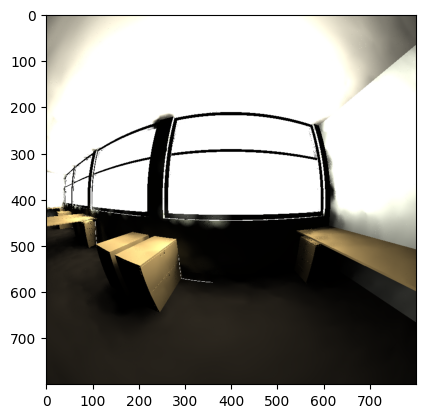

In [48]:
with open("raw.hdr", "wb") as f:
    f.write(img)
# img_tm = pr.pcond("raw.hdr", human=True)
# img_tm = pr.pcond(img, human=True)
# _, yres, _, xres = pr.getinfo(img, dimension_only=True).decode().split()
# xres, yres = int(xres), int(yres)
xres, yres = pr.get_image_dimensions(img)
# img_data = pr.pvalue(img_tm, header=False, outform='f', resstr=False)
img_data = pr.pvalue(img, header=False, outform='f', resstr=False)
img_array = np.frombuffer(img_data, dtype=np.single).reshape(xres, yres, 3)
plt.imshow(img_array)

### Luminance falsecoloring

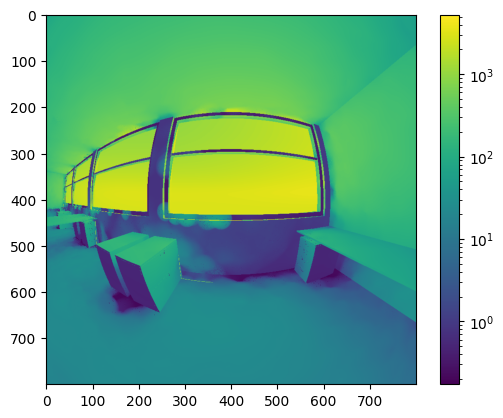

In [49]:
img_data = pr.pvalue(img, header=False, outform='f', resstr=False)
img_array = np.frombuffer(img_data, dtype=np.single).reshape(xres, yres, 3)
luminance = img_array[:, :, 0] * 47.4 + img_array[:, :, 1] * 119.9 + img_array[:, :, 2] * 11.6
plt.imshow(luminance, cmap='viridis', norm=mpl.colors.LogNorm())
plt.colorbar()

### Set sampling parameters

In [50]:
sp = pr.SamplingParameters()
sp.aa = 0
sp.ad = 32
sp.ab = 2

AttributeError: module 'pyradiance' has no attribute 'SamplingParameters'

### Rendering with rtpict

In [ ]:
img = pr.rtpict(my_view, my_scene.octree, xres=3200, yres=3200, nproc=8, params=sp.args())

### Tone-mapping

In [ ]:
with open("raw2.hdr", "wb") as f:
    f.write(pr.pfilt(img, one_pass=True, xres="/4", yres="/4", gaussian_filter_radius=0.6))
img_arr = np.frombuffer(pr.pvalue(pr.pcond("raw2.hdr", human=True), header=False, outform='f', resstr=False), dtype=np.single).reshape(800, 800, 3)

In [ ]:
plt.imshow(img_arr)

### BSDF analysis

In [ ]:
ttree = pr.BSDF("./ms6858_g6.xml")

In [ ]:
ttree.info
ttree.components

In [ ]:
klems = pr.BSDF("./ms6858_kf.xml")
klems.info
klems.components

In [ ]:
ttree_tau_h = []
klems_tau_h = []
for i in range(90):
    ttree_tau_h.append(ttree.direct_hemi(i, 0, 't'))
    klems_tau_h.append(klems.direct_hemi(i, 0, 't'))

In [ ]:
plt.plot(ttree_tau_h, label="ttree")
plt.plot(klems_tau_h, label="klems")
plt.xlabel("theta (deg)")
plt.ylabel("tau_h")
plt.legend()

### Generate spectral sky primitives

In [ ]:
ssky = pr.genssky(
    datetime.datetime.now(),
    latitude=40.8,
    longitude=111.9,
    timezone=105,
    nthreads=8,
)

In [ ]:
sky_glow = str(pr.Primitive("skyfunc", "glow", "skyglow", [], [1,1,1,0])).encode()
sky_source = str(pr.Primitive("skyglow", "source", "skydome", [], [0,0,1,180])).encode()
ground_source = str(pr.Primitive("skyglow", "source", "groundplane", [], [0,0,-1,180])).encode()

### Modify this to generate the octree, right now it only contains the skys

In [ ]:
with open("sky.oct", "wb") as f: f.write(pr.oconv(stdin=ssky+sky_glow+sky_source+ground_source))

### Render an image